<a href="https://colab.research.google.com/github/captain-pool/hub/blob/add_ESRGAN_colab/examples/colab/image_enhancing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the \"License\");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

### Image Super Resolution using ESRGAN

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)] for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

In [0]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

**Preparing Environment**

In [0]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
tf.enable_v2_behavior()
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [0]:
!wget "http://v3wall.com/wallpaper/1920_1200/1412/1920_1200_20141203080119557960.jpg" -O original.jpg

--2019-08-20 20:13:58--  http://v3wall.com/wallpaper/1920_1200/1412/1920_1200_20141203080119557960.jpg
Resolving v3wall.com (v3wall.com)... 67.229.138.10
Connecting to v3wall.com (v3wall.com)|67.229.138.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 517101 (505K) [image/jpeg]
Saving to: ‘original.jpg’

original.jpg        100%[===================>] 504.98K  1.05MB/s    in 0.5s    

2019-08-20 20:13:58 (1.05 MB/s) - ‘original.jpg’ saved [517101/517101]



In [0]:
# Declaring Constants
IMAGE_PATH = "original.jpg"
SAVED_MODEL_PATH = "https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz"

In [0]:
def preprocess_image(image_path, crop_size=[128, 128]):
  """
      Loads image from path and scales down using bicubic downsampling.
      Args:
          image_path: Path to the image file.
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  _can_calculate_psnr = False
  if hr_image.shape[0] >= crop_size[0] and hr_image.shape[1] >= crop_size[1]:
      hr_image = tf.image.random_crop(hr_image, [crop_size[0], crop_size[1], 3])
      _can_calculate_psnr = True

  lr_image = np.asarray(
      Image.fromarray(hr_image.numpy())
      .resize([crop_size[0] // 4, crop_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  hr_image = tf.cast(hr_image, tf.float32)
  return lr_image, hr_image, _can_calculate_psnr

In [0]:
# Defining helper functions
def _maybe_clip_values(image):
  """
    If floating point image, clips the pixel values between [0, 255]
    Args:
      image: content of the image as floating point matrix
  """
  if not image.dtype is tf.uint8:
    image = tf.clip_by_value(image, 0, 255)
  return image

def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save to.
  """
  if not isinstance(image, Image.Image):
    image = _maybe_clip_values(image)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)


In [0]:
% matplotlib inline
def plot_image(image, title="", save=False):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = _maybe_clip_values(image)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  if save:
    save_image(image, title)
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)
  plt.show()

In [0]:
lr_image, hr_image, _can_calculate_psnr = preprocess_image(IMAGE_PATH, [512, 512])

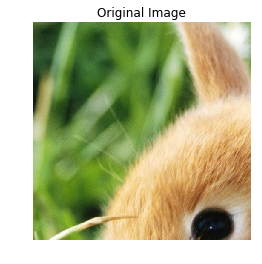

In [0]:
# Plotting Original Resolution image
plot_image(hr_image, title="Original Image", save=True)

In [0]:
model = hub.load(SAVED_MODEL_PATH)

Downloaded https://github.com/captain-pool/GSOC/releases/download/1.0.0/esrgan.tar.gz, Total size: 20.94MB



In [0]:
start = time.time()
fake_image = model.call(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 5.821034


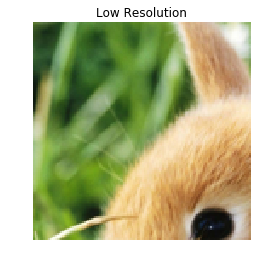

In [0]:
# Plotting Low Resolution Image
plot_image(tf.squeeze(lr_image), "Low Resolution", save=True)

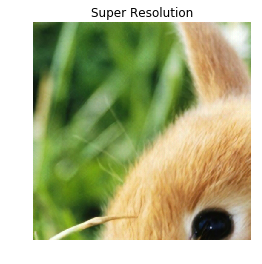

PSNR Achieved: 35.195499


In [0]:
# Plotting Super Resolution Image
plot_image(tf.squeeze(fake_image), "Super Resolution", save=True)
# Calculating PSNR wrt Original Image
if _can_calculate_psnr:
  print("PSNR Achieved: %f" % tf.image.psnr(
      tf.clip_by_value(fake_image, 0, 255),
      tf.clip_by_value(hr_image, 0, 255), max_val=255))